In [3]:
import PIL
from PIL import Image
from torchvision import transforms

import torch
import torchvision
import numpy as np

In [4]:
# 마스크 뽑기

def extract_mask(input_original, input_sketch):
    img_original = PIL.Image.open(input_original).resize((256, 256))
    img_sketch = PIL.Image.open(input_sketch).resize((256, 256))
    to_tensor = transforms.ToTensor()

    # 원본 이미지, sketch 추가된 이미지 불러오기
    img_original_tensor = to_tensor(img_original)
    img_original_tensor = img_original_tensor[:3, :, :]
    img_sketch_tensor = to_tensor(img_sketch)
    img_sketch_tensor = img_sketch_tensor[:3, :, :]

    # 두 이미지 차이 계산 후 0, 1 binary mask 생성
    mask_tensor = img_original_tensor - img_sketch_tensor
    mask_tensor = torch.clamp(torch.abs(mask_tensor), min=0, max=1)
    for i in range(len(mask_tensor[0])):
        for j in range(len(mask_tensor[0][0])):
            if mask_tensor[0][i][j] > 0.01:
                continue
            else:
                mask_tensor[0][i][j]=0

    mask_tensor = torch.ones(mask_tensor.size()) - torch.ceil(mask_tensor)

    return img_sketch_tensor, mask_tensor

In [5]:
# 마스크 부분 전처리
import copy

dx = [1, -1, 0, 0, 1, -1, 1, -1]
dy = [0, 0, -1, 1, -1, -1, 1, 1]
def bfs(i, j,mask):
    count=1
    change_list=[]
    s[i][j] = 1
    queue = [[i, j]]
    while queue:
        a, b = queue[0][0], queue[0][1]
        del queue[0]
        for k in range(8):
            x = a + dx[k]
            y = b + dy[k]
            if 0 <= x < len(s[0]) and 0 <= y < len(s) and s[x][y] == 0:
                s[x][y] = 1
                queue.append([x, y])
                change_list.append([x,y])
                count+=1
    if count<20:
        for change in change_list:
            mask[change[0]][change[1]]=1
        return change_list, False
    else:   
        return change_list, True


count :  8403


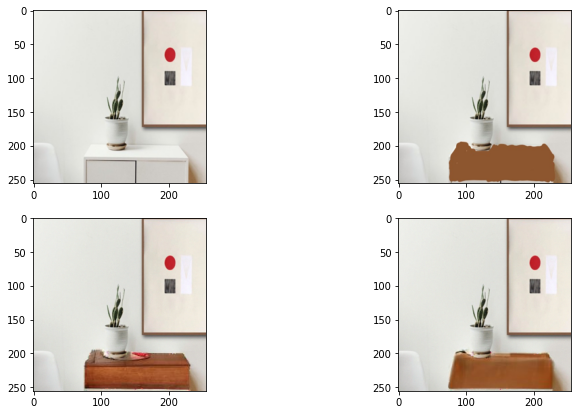

In [8]:
image_num='0044'

origin_path='/opt/ml/SDEdit/original_image/bedroom_original_' + image_num+'.png'
sketch_path='/opt/ml/SDEdit/sketch_image/bedroom_sketch_'+ image_num+'.png'
path='/opt/ml/SDEdit/result/bedroom0'+image_num[-1]+'_result/bedroom_generated_'
result = ['0'*(4-len(str(i))) + str(i) for i in range(48*int(image_num),48*int(image_num)+80)]

_,mask=extract_mask(origin_path,sketch_path)

# 마스크 부분 직사각형 구하기
s = copy.deepcopy(mask[0])
cnt = 0
find_list=[]
for i in range(len(mask[0])):
    for j in range(len(mask[0][0])):
        if s[i][j] == 0:
            find,boolen=bfs(i,j,mask[0])
            if boolen:
                find_list.append(find)
            
np_min=np.min(np.array(find_list[0]),axis=0)
np_max=np.max(np.array(find_list[0]),axis=0)


# 모델 불러오기
model = torchvision.models.resnet18(pretrained=True)

# 마스크 부분을 모델에 넣기 -> category 찾기
img_original = PIL.Image.open(origin_path).resize((256, 256))
to_tensor = transforms.ToTensor()
img_original_tensor = to_tensor(img_original)
img_original_tensor = img_original_tensor[:3, :, :]
img=np.array([[[float(j) for j in i[np_min[1]:np_max[1]]] for i in img_original_tensor[channel][np_min[0]:np_max[0]]] for channel in range(3)])
img=to_tensor(img)
img=img.permute(1,2,0)
img = torch.unsqueeze(img,0)
if torch.cuda.is_available():
    img = img.to('cuda',dtype=torch.float)
    model.to('cuda')

model.eval()
out = model(img)
pred = torch.argmax(out, dim=-1)


# 생성된 모든 그림에 원하는 category 값 찾기
anw=[]
for i in result:
    img_path=path+i+'.png'
    img = PIL.Image.open(img_path).resize((256, 256))
    img = to_tensor(img)
    img= img[:3, :, :]
    img=np.array([[[float(j) for j in i[np_min[1]:np_max[1]]] for i in img_original_tensor[channel][np_min[0]:np_max[0]]] for channel in range(3)])
    img=to_tensor(img)
    img=img.permute(1,2,0)
    img = torch.unsqueeze(img,0)
    if torch.cuda.is_available():
        img = img.to('cuda',dtype=torch.float)
        
    ###### 이미지를 새로 그린 경우 그 이미지에 맞는 imagenet label 넣기
    # anw.append([i,float(model(img)[0][559])])
    
    #### 이미지 위에 색칠한 경우
    anw.append([i,float(model(img)[0][int(pred)])])
    


# 이미지 불러오기

img_original = PIL.Image.open(origin_path).resize((256, 256))
img_original = to_tensor(img_original)
img_original = img_original[:3, :, :]


img_sketch = PIL.Image.open(sketch_path).resize((256, 256))
img_sketch = to_tensor(img_sketch)
img_sketch = img_sketch[:3, :, :]

# 시각화

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,7))
ax=fig.add_subplot(2,2,1)
ax.imshow(img_original.permute(1,2,0))
ax=fig.add_subplot(2,2,2)
ax.imshow(img_sketch.permute(1,2,0))

for i, (ind,_ )in enumerate(sorted(anw,key=lambda x : x[1], reverse=True)[:2]):
    change_path=path+str(ind)+'.png'
    img_original = PIL.Image.open(change_path).resize((256, 256))
    to_tensor = transforms.ToTensor()
    img_original_tensor = to_tensor(img_original)
    img = img_original_tensor[:3, :, :]
    ax=fig.add_subplot(2,2,i+3)
    ax.imshow(img.permute(1,2,0))
    